#Description of the notebook

Students:
- Teka Kimbi Ntimanputu (10673197)
- William Stucchi (10661711)
- Lorenzo Veronese (10654901)

Starting from the model covered in the lab sessions, we began with a modified version of the VGG9 model, tailoring it to our specific needs. We particularly focused on refining the image preprocessing phase within the dataset to enhance the model's versatility and reduce the risk of overfitting.
The following image augmentation techniques were introduced:

*   Random Cut and Hide&Seek
*   Noise
*   Color inversion




#FLAGS

In [1]:
CLASS_WEIGHTS=True
OVERSAMPLING=False
NOISE=False
RANDOM_ERASING=False
HIDE_SEEK=False
INVERT_COLORS=False

# Import libraries

In [2]:
#Connect to drive
from google.colab import drive

In [3]:
from numpy import load
import numpy as np
from google.colab.patches import cv2_imshow
from PIL import Image, ImageOps

In [4]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [5]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [6]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import math

In [7]:
drive.mount('/gdrive')
%cd /gdrive/My Drive/ChallengeAN2DL/Homework1

Mounted at /gdrive
/gdrive/My Drive/ChallengeAN2DL/Homework1


# Loading dataset


In the following lines of code the dataset is loaded and divided into an image set and a label set

In [8]:
#load data
data = load('public_data.npz', allow_pickle=True)
lst = data.files

In [9]:
#Divide the dataset in image set and label set
img_set = data['data']
label_set = data['labels']


In [10]:
#Inspect the shape and the type
print(data['data'][0].shape)
print(type(data['data'][0]))

(96, 96, 3)
<class 'numpy.ndarray'>


#Inspect Data

The dataset is displayed in order to perform an initial inspection on the data, allowing to underatand its content

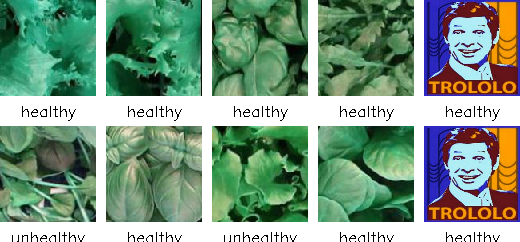

In [11]:
# Calculate the canvas size based on image and label dimensions
num_images = len(img_set)
num_to_display = 10
vertical_spacing = 10
horizontal_spacing = 10

max_image_height = max(img.shape[0] for img in img_set)
image_width = img_set[0].shape[1]
label_height = 20
canvas_height = 2 * (max_image_height + label_height) + vertical_spacing
canvas_width = 5 * image_width + 4 * horizontal_spacing

canvas = np.ones((canvas_height, canvas_width, 3), dtype=np.uint8) * 255
random_indices = random.sample(range(num_images), num_to_display)

# Arrange and display the images and labels with spacing
for i, index in enumerate(random_indices):
    row = i // 5
    col = i % 5
    y_offset = row * (max_image_height + label_height + vertical_spacing)
    x_offset = col * (image_width + horizontal_spacing)

    img = img_set[index]
    canvas[y_offset:y_offset + img.shape[0], x_offset:x_offset + image_width, :] = img

    label_text = label_set[index]
    label_size, _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    label_x = x_offset + (image_width - label_size[0]) // 2
    label_y = y_offset + img.shape[0] + label_height
    cv2.putText(canvas, label_text, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

cv2_imshow(canvas)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Data Cleaning

Due to the presence of evident outliers within the dataset, a data cleaning operation was conducted to prepare the the data splitting phase and subsequent training phase.

## Shrek

In [12]:
# Reference image 'shrek'
shrek = img_set[58]

# List to store the indexes of images to remove
indexes_to_remove = []

# Iterate through the image set to identify occurrences of 'shrek'
for i in range(0, len(img_set)):
    if np.array_equal(shrek, img_set[i]):
        indexes_to_remove.append(i)

print("Indexes to remove:", indexes_to_remove)
print("Number of indexes to remove:", len(indexes_to_remove))

Indexes to remove: [58, 95, 137, 138, 171, 207, 506, 571, 599, 622, 658, 692, 779, 827, 840, 880, 901, 974, 1028, 1265, 1268, 1280, 1333, 1443, 1466, 1483, 1528, 1554, 1594, 1651, 1806, 1866, 1938, 1977, 2022, 2081, 2090, 2261, 2311, 2328, 2380, 2435, 2451, 2453, 2515, 2663, 2665, 2675, 2727, 2734, 2736, 2755, 2779, 2800, 2830, 2864, 2866, 2913, 2937, 3033, 3055, 3105, 3144, 3155, 3286, 3410, 3488, 3572, 3583, 3666, 3688, 3770, 3801, 3802, 3806, 3811, 3862, 3885, 3927, 3931, 3946, 3988, 4097, 4118, 4144, 4150, 4282, 4368, 4475, 4476, 4507, 4694, 4740, 4779, 4857, 5082, 5121, 5171]
Number of indexes to remove: 98


In [13]:
print("Length before removing Shrek: ", len(img_set))

#Remove the images and the labels related to the outliers
img_set = img_set[~np.isin(np.arange(len(img_set)), indexes_to_remove)]
label_set = label_set[~np.isin(np.arange(len(label_set)), indexes_to_remove)]

print("Length after removing Shrek: ", len(img_set))

Length before removing Shrek:  5200
Length after removing Shrek:  5102


## Trololo

In [14]:
# Rreference image 'trololo'
trololo = img_set[332]  # Note: It is 332 AFTER removing 'Shrek'

#List to store the indexes of images to remove
indexes_to_remove = []

# Iterate through the image set to identify occurrences of 'trololo'
for i in range(0, len(img_set)):
    if np.array_equal(trololo, img_set[i]):
         indexes_to_remove.append(i)

print("Indexes to remove:", indexes_to_remove)
print("Number of indexes to remove:", len(indexes_to_remove))

Indexes to remove: [332, 406, 428, 480, 522, 689, 711, 713, 741, 770, 882, 944, 954, 971, 1025, 1045, 1046, 1082, 1130, 1153, 1171, 1172, 1361, 1514, 1580, 1601, 1660, 1667, 1722, 1727, 1729, 1797, 1871, 1906, 1947, 1954, 2113, 2154, 2155, 2161, 2308, 2385, 2443, 2452, 2519, 2536, 2548, 2551, 2628, 2743, 2776, 2784, 2832, 2871, 2989, 3025, 3046, 3311, 3370, 3385, 3423, 3629, 3669, 3728, 3745, 3759, 3818, 3821, 3826, 3869, 3883, 3907, 3967, 3973, 4017, 4223, 4227, 4229, 4323, 4413, 4466, 4514, 4527, 4627, 4643, 4673, 4743, 4754, 4765, 4788, 4802, 4808, 4812, 4832, 4953, 4985, 5046, 5068]
Number of indexes to remove: 98


In [15]:
print("Length before removing Trololo: ", len(img_set))

#Remove the images and the labels related to the outliers
img_set = img_set[~np.isin(np.arange(len(img_set)), indexes_to_remove)]
label_set = label_set[~np.isin(np.arange(len(label_set)), indexes_to_remove)]

print("Length after removing Trololo: ", len(img_set))

Length before removing Trololo:  5102
Length after removing Trololo:  5004


# Distributions

The data distribution across different classes was visualized using a histogram

In [16]:
# Create a list of unique classes in your label set
unique_classes = np.unique(label_set)
# Count the occurrences of each class
class_counts = [np.sum(label_set == c) for c in unique_classes]
# Number of bins,bar width, separation between bars and their position
n_bins = len(unique_classes)
bar_width = 0.4
bar_spacing = 0.2
x_positions = np.arange(len(unique_classes))
colors = ['green', 'brown']

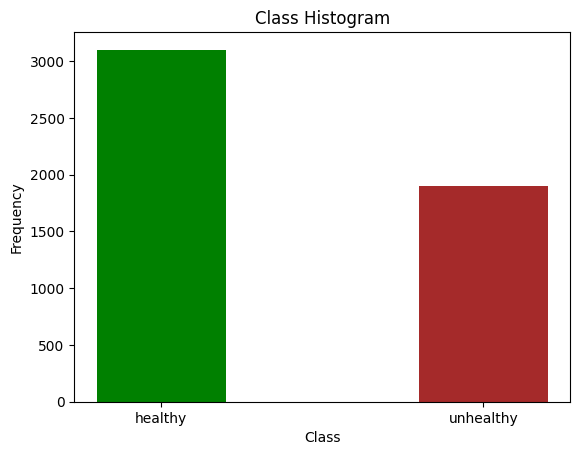

In [17]:
# Plot the histogram with colored bars and adjusted spacing
plt.bar(x_positions, class_counts, width=bar_width, color=colors)
plt.xticks(x_positions, unique_classes)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Histogram')
plt.show()

# Image Augmentation Playground

The actual augmentation takes place later in the notebook. This section serves as an area to experiment with different augmentation techniques, allowing for a safe exploration of their effects.

## Function for displaying the transformations

In [18]:
def display_transformation(img_set,X_train_flip):

  num_images = len(img_set)
  num_to_display = 5
  vertical_spacing = 10
  horizontal_spacing = 10

  # Calculate the canvas size based on image dimensions
  max_image_height = max(img.shape[0] for img in img_set)
  image_width = img_set[0].shape[1]
  label_height = 20
  canvas_height = 2 * (max_image_height + label_height) + vertical_spacing
  canvas_width = 5 * image_width + 4 * horizontal_spacing
  canvas = np.ones((canvas_height, canvas_width, 3), dtype=np.uint8) * 255
  random_indices_set = random.sample(range(num_images), num_to_display)

    # Arrange and display the images and labels with spacing
  for i in range(num_to_display):
      img1 = img_set[random_indices_set[i]]
      y_offset = 0
      x_offset = i * (image_width + horizontal_spacing)
      canvas[y_offset:y_offset + img1.shape[0], x_offset:x_offset + image_width, :] = img1

      img2 = X_train_flip[random_indices_set[i]]
      y_offset = max_image_height + label_height + vertical_spacing
      x_offset = i * (image_width + horizontal_spacing)
      canvas[y_offset:y_offset + img2.shape[0], x_offset:x_offset + image_width, :] = img2

      label_text = label_set[i]
      label_size, _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
      label_x = x_offset + (image_width - label_size[0]) // 2
      label_y = y_offset + img.shape[0] + label_height
      cv2.putText(canvas, label_text, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

  cv2_imshow(canvas)
  cv2.waitKey(0)
  cv2.destroyAllWindows()


## Horizontal Flip

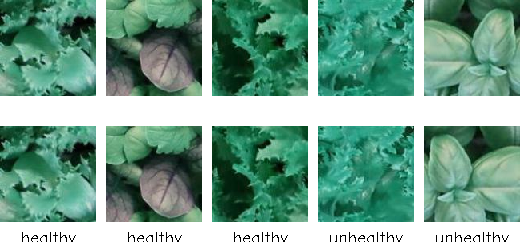

In [19]:
#RandomFlip - Horizontal
flip = tf.keras.Sequential([
  tfkl.RandomFlip("horizontal"),
])

X_train_flip = flip(img_set)
display_transformation(img_set,X_train_flip)

## Random Translation

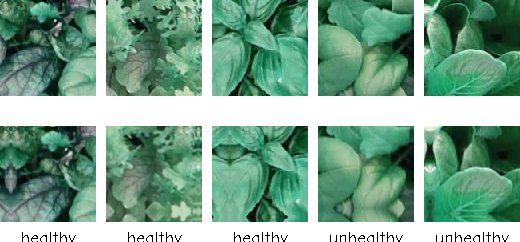

In [20]:
translation = tf.keras.Sequential([
  tfkl.RandomTranslation(0.2,0.2),
])

X_train_translation = translation(img_set)
display_transformation(img_set,X_train_translation)

##Random Rotation

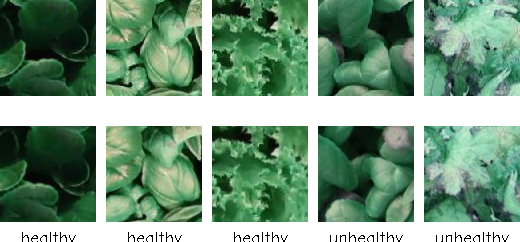

In [21]:
rotation = tf.keras.Sequential([
  tfkl.RandomRotation(0.2),
])

X_train_rotation = rotation(img_set)
display_transformation(img_set,X_train_rotation)

##Random Zoom

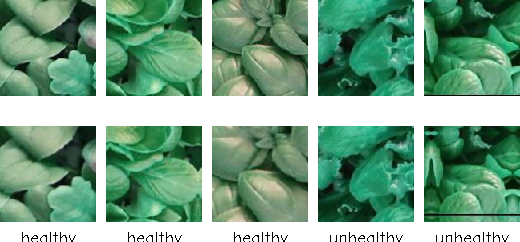

In [22]:
zoom = tf.keras.Sequential([
  tfkl.RandomZoom(0.2),
])

X_train_zoom = zoom(img_set)
display_transformation(img_set,X_train_zoom)

## Noise


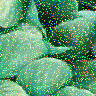

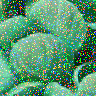

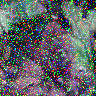

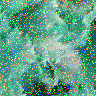

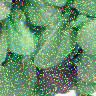

In [23]:
num_samples = 5

# Initialize an empty list to store the sampled and noisy images
sampled_noisy_images = []

# Loop to sample and process the images
for i in range(num_samples):
    random_index = np.random.randint(len(img_set))
    image = img_set[random_index].copy()
    # Add noise to the image (e.g., Gaussian noise)
    noise = np.random.normal(0, 0.8, image.shape).astype(np.uint8)
    noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)
    cv2_imshow(noisy_image)

##Hide and Seek

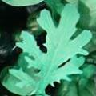

In [24]:
# Define parameters for random erasing
probability = 0.5
min_area = 0.003
max_area = 0.04
min_aspect_ratio = 0.3
max_aspect_ratio = 0.8
image = img_set[0].copy()
num_dots =  np.random.randint(10,20)
cv2_imshow(image)


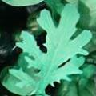

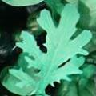

In [25]:
# Calculate the total area of the image
total_area = image.shape[0] * image.shape[1]
# Check if random erasing should be applied
if np.random.rand() < probability:
    for i in range(num_dots):
      erasing_area = np.random.uniform(min_area, max_area) * total_area
      aspect_ratio = np.random.uniform(min_aspect_ratio, max_aspect_ratio)
      # Dimensions of the erasing region
      erasing_width = int(np.sqrt(erasing_area * aspect_ratio))
      erasing_height = int(np.sqrt(erasing_area / aspect_ratio))
      # Randomly select the position of the erasing region
      x = np.random.randint(0, image.shape[1] - erasing_width)
      y = np.random.randint(0, image.shape[0] - erasing_height)
      # Apply random erasing by setting the selected region to black
      image[y:y+erasing_height, x:x+erasing_width, :] = 0

cv2_imshow(image)
cv2_imshow(img_set[0])


##Random erasing

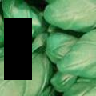

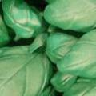

In [26]:
# Define parameters for random erasing
min_area = 0.08
max_area = 0.3
min_aspect_ratio = 0.3
max_aspect_ratio = 3.0

# Calculate the total area of the image
total_area = img_set[0].shape[0] * img_set[0].shape[1]
image_rd = img_set[1].copy()
erasing_area = np.random.uniform(min_area, max_area) * total_area
aspect_ratio = np.random.uniform(min_aspect_ratio, max_aspect_ratio)

# Calculate the dimensions of the erasing region
erasing_width = int(np.sqrt(erasing_area * aspect_ratio))
erasing_height = int(np.sqrt(erasing_area / aspect_ratio))

# Randomly select the position of the erasing region
x = np.random.randint(0, image_rd.shape[1] - erasing_width)
y = np.random.randint(0, image_rd.shape[0] - erasing_height)
# Apply random erasing by setting the selected region to black
image_rd[y:y+erasing_height, x:x+erasing_width, :] = 0


cv2_imshow(image_rd)
cv2_imshow(img_set[1])

#Build the model

##Convert to categorical data

In [27]:
# Define a mapping from label strings to numerical values
labels_string_to_num = {'healthy': 0, 'unhealthy': 1}

# Iterate through the label_set and replace label strings with their corresponding numerical values
for i in range(0, len(label_set)):
    label_set[i] = labels_string_to_num[label_set[i]]

# Expand the label_set to have an additional dimension for compatibility with later operations
label_num = np.expand_dims(label_set, axis=-1)

# Print the shape of the label_num array
print(label_num.shape)

# Convert numerical labels to one-hot encoded categorical labels using TensorFlow's to_categorical function
label_cat = tfk.utils.to_categorical(label_num, num_classes=2)

# Print the one-hot encoded label for the first data point
print(label_cat[0])

(5004, 1)
[1. 0.]


##Spilt the dataset

In [28]:
# Split data into train_val and test sets
X_train, X_val, y_train, y_val = train_test_split(img_set, label_cat, random_state=seed, test_size=.20, stratify=np.argmax(label_cat, axis=1))

In [29]:
# Normalize data to the range [0, 1]
X_train = (X_train / 255).astype('float32')
X_val = (X_val / 255).astype('float32')

In [30]:
# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (4003, 96, 96, 3), y_train shape: (4003, 2)
X_val shape: (1001, 96, 96, 3), y_val shape: (1001, 2)


##Imbalanced dataset

###Class weight Method

To counteract imbalanced datasets, the approach of class weights is adopted,
wherein differents weights are allocated to classes determined by their frequencies within the dataset.

In [31]:
if CLASS_WEIGHTS:
  # Scaling by total/2 helps keep the loss to a similar magnitude.
  num_healthy = np.count_nonzero(label_set == 0)
  num_unhealthy = np.count_nonzero(label_set == 1)

  # Calculate the total number of samples
  total = num_healthy + num_unhealthy

  # Class weight for 0 (healthy)
  # Weight for class 0 is scaled to help keep the loss to a similar magnitude, ensuring that the sum of weights stays the same.
  weight_for_0 = (1 / num_healthy) * (total / 2.0)
  # Class weight for 1 (unhealthy)
  weight_for_1 = (1 / num_unhealthy) * (total / 2.0)

  class_weight = {0: weight_for_0, 1: weight_for_1}
  print('Weight for class 0 (healthy): {:.2f}'.format(weight_for_0))
  print('Weight for class 1 (unhealthy): {:.2f}'.format(weight_for_1))

Weight for class 0 (healthy): 0.81
Weight for class 1 (unhealthy): 1.31


###Oversampling from the minority class

To counteract imbalanced datasets, the approach of oversampling is adopted,by adding to the train set random images from the minority class.

In [32]:
if OVERSAMPLING:
  # list to store the indexes of the majority class samples
  majority_class_indexes = []

  # Iterate through the training labels to identify the majority class samples
  for item in range(len(y_train)):
      # Check if the current label is not the same as the 'unhealthy' class
      if (y_train[item][0] == 1.0 and y_train[item][1]==0.0):
          majority_class_indexes.append(item)
          #print(item)

  # Create a subset of unhealthy and healthy features based on the majority class indexes
  unhealthy_features = X_train[~np.isin(np.arange(len(X_train)), majority_class_indexes)]
  healthy_features = X_train[np.isin(np.arange(len(X_train)), majority_class_indexes)]

  # Create a subset of unhealthy and healthy labels based on the majority class indexes
  unhealthy_labels = y_train[~np.isin(np.arange(len(y_train)), majority_class_indexes)]
  healthy_labels = y_train[np.isin(np.arange(len(y_train)), majority_class_indexes)]

  print('Num Unhealthy: ',len(unhealthy_labels))
  print('Num Healthy: ',len(healthy_labels))


In [33]:
if OVERSAMPLING:
  if(len(unhealthy_labels) < len(healthy_labels)):
    # Array of sequential IDs for the unhealthy features
    ids = np.arange(len(unhealthy_features))

    # Randomly sample IDs from the unhealthy features to match the number of healthy features
    choices = np.random.choice(ids, len(healthy_features))

    # Set of resampled unhealthy features based on the chosen IDs
    res_unhealthy_features = unhealthy_features[choices]

    # Set of resampled unhealthy labels using the same chosen IDs
    res_unhealthy_labels = unhealthy_labels[choices]

    print("Shape of resampled unhealthy features:", res_unhealthy_features.shape)

  else:
    # Array of sequential IDs for the healthy features
    ids = np.arange(len(healthy_features))

    # Randomly sample IDs from the healthy features to match the number of unhealthy features
    choices = np.random.choice(ids, len(unhealthy_features))

    # Set of resampled unhealthy features based on the chosen IDs
    res_healthy_features = healthy_features[choices]

    # Set of resampled unhealthy labels using the same chosen IDs
    res_healthy_labels = healthy_labels[choices]

    print("Shape of resampled healthy features:", res_healthy_features.shape)



In [34]:
if OVERSAMPLING:
  if(len(unhealthy_labels) < len(healthy_labels)):
    X_train = np.concatenate([res_unhealthy_features, healthy_features], axis=0)
    y_train = np.concatenate([res_unhealthy_labels, healthy_labels], axis=0)
  else:
    X_train = np.concatenate([res_healthy_features, unhealthy_features], axis=0)
    y_train = np.concatenate([res_healthy_labels, unhealthy_labels], axis=0)

  order = np.arange(len(X_train))
  np.random.shuffle(order)
  X_train = X_train[order]
  y_train = y_train[order]
  X_train.shape

## Image Augmentation

Images are prepared to undergo to the data augmentation process.The images can possibly undergo to the following augmentation processes:


*   Random Erasing
*   Noise
*   Hide and Seek
*   Invert colors



In [35]:
X_train_restored = (X_train * 255).astype('uint8')

### Noise

In [36]:
if NOISE:
  num_samples_noise = math.ceil(len(X_train)*0.20)
  # List to store the sampled and noisy images
  sampled_noisy_images = []
  sampled_noisy_labels = []

  for i in range(num_samples_noise):
      # Randomly select an image from the training set
      random_index = np.random.randint(len(X_train))
      image = X_train_restored[random_index].copy()

      # Add noise to the image
      noise = np.random.normal(0, 0.8, image.shape).astype(np.uint8)
      noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)
      sampled_noisy_images.append(noisy_image)
      sampled_noisy_labels.append(y_train[random_index])


  print(type(X_train))
  print(type(sampled_noisy_images))
  sampled_noisy_images = (np.array(sampled_noisy_images) / 255).astype('float32')


### Random erasing

In [37]:
if RANDOM_ERASING:
  num_samples_cut = math.ceil(len(X_train)*0.30)
  # Define parameters for random erasing
  min_area = 0.08
  max_area = 0.3
  min_aspect_ratio = 0.3
  max_aspect_ratio = 3.0

  sampled_cut_images = []
  sampled_cut_labels = []

  # Area of the image
  total_area = img_set[0].shape[0] * img_set[0].shape[1]

  for i in range(num_samples_cut):
      # Randomly select an image from the training set
      random_index_cut = np.random.randint(len(X_train))
      cut_image = X_train_restored[random_index_cut].copy()

      erasing_area = np.random.uniform(min_area, max_area) * total_area
      aspect_ratio = np.random.uniform(min_aspect_ratio, max_aspect_ratio)

      # Calculate the dimensions of the erasing region
      erasing_width = int(np.sqrt(erasing_area * aspect_ratio))
      erasing_height = int(np.sqrt(erasing_area / aspect_ratio))

      # select the position of the erasing region
      x = np.random.randint(0, cut_image.shape[1] - erasing_width)
      y = np.random.randint(0, cut_image.shape[0] - erasing_height)

      # Apply random erasingk
      cut_image[y:y+erasing_height, x:x+erasing_width, :] = 0

      sampled_cut_images.append(cut_image)
      sampled_cut_labels.append(y_train[random_index_cut])


  print(type(sampled_cut_images))
  sampled_cut_images = (np.array(sampled_cut_images) / 255).astype('float32')


###hide and seek

In [38]:
if HIDE_SEEK:
  num_samples_hide = math.ceil(len(X_train)*0.25)
  # Define parameters for Hide and seek
  probability = 0.3
  min_area_hide = 0.003
  max_area_hide = 0.004
  min_aspect_ratio_hide = 0.3
  max_aspect_ratio_hide = 0.8

  sampled_hide_images = []
  sampled_hide_labels = []

  # Area of the image
  total_area_hide = img_set[0].shape[0] * img_set[0].shape[1]

  for i in range(num_samples_hide):
      # Randomly select an image from the training set
      random_index_hide = np.random.randint(len(X_train))
      hide_image = X_train_restored[random_index_hide].copy()
      num_dots_hide = np.random.randint(10,20)
      if np.random.rand() < probability:
      # Randomly select the area and aspect ratio for erasing
        for i in range(num_dots_hide):
            erasing_area_hide = np.random.uniform(min_area_hide, max_area_hide) * total_area_hide
            aspect_ratio_hide = np.random.uniform(min_aspect_ratio_hide, max_aspect_ratio_hide)

            # Calculate the dimensions of the erasing region
            erasing_width_hide = int(np.sqrt(erasing_area_hide * aspect_ratio_hide))
            erasing_height_hide = int(np.sqrt(erasing_area_hide / aspect_ratio_hide))

            # Select the position of the erasing region
            x_hide = np.random.randint(0, hide_image.shape[1] - erasing_width_hide)
            y_hide = np.random.randint(0, hide_image.shape[0] - erasing_height_hide)

            # Apply random erasing
            hide_image[y_hide:y_hide+erasing_height_hide, x_hide:x_hide+erasing_width_hide, :] = 0

        sampled_hide_images.append(hide_image)
        sampled_hide_labels.append(y_train[random_index_hide])


  print(type(sampled_hide_images))

  for i in range(100):
    cv2_imshow(sampled_hide_images[i])
  sampled_hide_images = (np.array(sampled_hide_images) / 255).astype('float32')

###Invert Colors


In [39]:
if INVERT_COLORS:
  num_samples_inverted = math.ceil(len(X_train)*0.35)
  # list to store the sampled and noisy images
  sampled_inverted_images = []
  sampled_inverted_labels = []

  for i in range(num_samples_inverted):
      # Randomly select an image from the training set
      random_index_inverted = np.random.randint(len(X_train))
      image_inverted = X_train_restored[random_index_inverted].copy()

      image_inverted = 255 - image_inverted
      #cv2_imshow(image_inverted)
      sampled_inverted_images.append(image_inverted)
      sampled_inverted_labels.append(y_train[random_index_inverted])

  print(type(sampled_inverted_images))
  sampled_inverted_images = (np.array(sampled_inverted_images) / 255).astype('float32')

###Concatenate

Add to the train set the augmented data

####Inverted


In [40]:
if INVERT_COLORS:
  # Concatenate the sampled and inverted images into a single NumPy array
  X_train = np.concatenate([sampled_inverted_images, X_train], axis=0)
  y_train = np.concatenate([sampled_inverted_labels, y_train], axis=0)
  print(len(X_train))

####Noise

In [41]:
if NOISE:
  # Concatenate the sampled and noisy images into a single NumPy array
  X_train = np.concatenate([sampled_noisy_images, X_train], axis=0)
  y_train = np.concatenate([sampled_noisy_labels, y_train], axis=0)
  print(len(X_train))

####Random Erasing

In [42]:
if RANDOM_ERASING:
  # Concatenate the sampled and the images from random erasing into a single NumPy array
  X_train = np.concatenate([sampled_cut_images, X_train], axis=0)
  y_train = np.concatenate([sampled_cut_labels, y_train], axis=0)
  print(len(X_train))

####Hide and Seek

In [43]:
if HIDE_SEEK:
  # Concatenate the sampled and the images from hide and seek into a single NumPy array
  X_train = np.concatenate([sampled_hide_images, X_train], axis=0)
  y_train = np.concatenate([sampled_hide_labels, y_train], axis=0)
  print(len(X_train))

##Model

Define the key paramenters of the model

In [48]:
# Define key model parameters
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]
batch_size = 64
epochs = 150

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Epochs: 150
Batch Size: 64
Input Shape: (96, 96, 3)
Output Shape: 2


define the architecture of the model

In [49]:
def build_quasiVGG9(input_shape, output_shape, seed=seed):
    tf.random.set_seed(seed)

    preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip("horizontal"),
        tfkl.RandomFlip("vertical"),
        tfkl.RandomZoom(0.2),
        tfkl.RandomTranslation(0.3,0.3),
    ], name='preprocessing')

     # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    preprocessing = preprocessing(input_layer)

    x = tfkl.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',name='conv00' , kernel_initializer = tf.keras.initializers.GlorotNormal(seed))(input_layer)
    #x = tfkl.BatchNormalization(name='bn00')(x)
    x = tfkl.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',name='conv01', kernel_initializer = tf.keras.initializers.GlorotNormal(seed))(x)
    #x = tfkl.BatchNormalization(name='bn01')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    x = tfkl.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu',name='conv10', kernel_initializer = tf.keras.initializers.GlorotNormal(seed))(x)
    #x = tfkl.BatchNormalization(name='bn02')(x)
    x = tfkl.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu',name='conv11', kernel_initializer = tf.keras.initializers.GlorotNormal(seed))(x)
    #x = tfkl.BatchNormalization(name='bn03')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu',name='conv20', kernel_initializer = tf.keras.initializers.GlorotNormal(seed))(x)
    #x = tfkl.BatchNormalization(name='bn04')(x)
    x = tfkl.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu',name='conv21', kernel_initializer = tf.keras.initializers.GlorotNormal(seed))(x)
    #x = tfkl.BatchNormalization(name='bn05')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(filters=256,kernel_size=3,padding='same',activation='relu',name='conv30',kernel_initializer = tf.keras.initializers.GlorotNormal(seed))(x)
    #x = tfkl.BatchNormalization(name='bn06')(x)
    x = tfkl.Conv2D(filters=256,kernel_size=3,padding='same',activation='relu',name='conv31',kernel_initializer = tf.keras.initializers.GlorotNormal(seed))(x)
    #x = tfkl.BatchNormalization(name='bn07')(x)
    x = tfkl.Conv2D(filters=256,kernel_size=3,padding='same',activation='relu',name='conv32',kernel_initializer = tf.keras.initializers.GlorotNormal(seed))(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)

    x = tfkl.Conv2D(filters=512,kernel_size=3,padding='same',activation='relu',name='conv40',kernel_initializer = tf.keras.initializers.GlorotNormal(seed))(x)
    #x = tfkl.BatchNormalization(name='bn06')(x)
    x = tfkl.Conv2D(filters=512,kernel_size=3,padding='same',activation='relu',name='conv41',kernel_initializer = tf.keras.initializers.GlorotNormal(seed))(x)
    #x = tfkl.BatchNormalization(name='bn07')(x)
    x = tfkl.Conv2D(filters=512,kernel_size=3,padding='same',activation='relu',name='conv42',kernel_initializer = tf.keras.initializers.GlorotNormal(seed))(x)
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    x = tfkl.Dropout(0.33)(x)
    x = tfkl.Dense(units=512 ,activation='relu',name='Dense2',kernel_initializer = tf.keras.initializers.GlorotNormal(seed))(x)


    output_layer = tfkl.Dense(units=output_shape,activation='softmax',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='Convnet')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate = 0.00004 ,weight_decay=5e-4), metrics=['accuracy'])

    # Return the model
    return model

Model: "Convnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv00 (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 conv01 (Conv2D)             (None, 96, 96, 32)        9248      
                                                                 
 mp0 (MaxPooling2D)          (None, 48, 48, 32)        0         
                                                                 
 conv10 (Conv2D)             (None, 48, 48, 64)        18496     
                                                                 
 conv11 (Conv2D)             (None, 48, 48, 64)        36928     
                                                                 
 mp1 (MaxPooling2D)          (None, 24, 24, 64)        0   

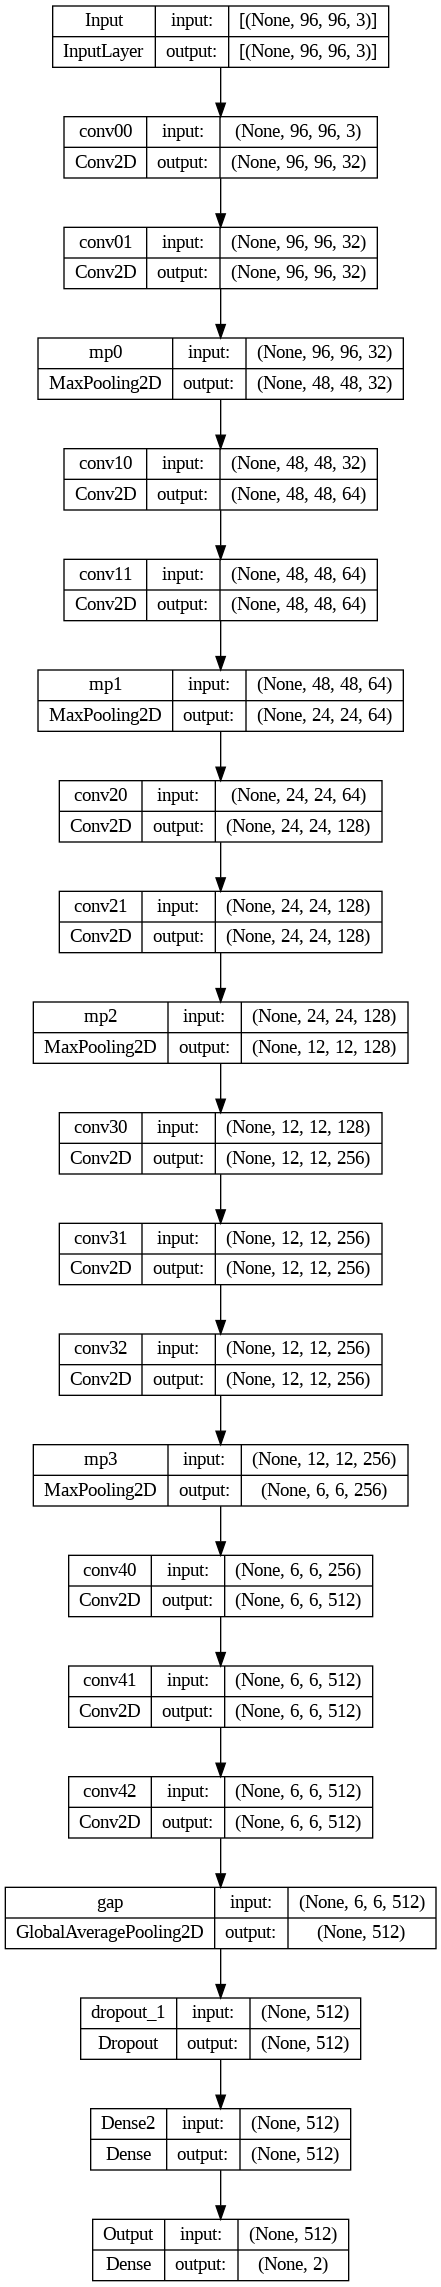

In [50]:
quasiVGG9 = build_quasiVGG9(input_shape, output_shape)
quasiVGG9.summary()
tfk.utils.plot_model(quasiVGG9, expand_nested=True, show_shapes=True)

#Train the model

Train the model with early stopping

In [51]:
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, mode='auto'),
]

# Train the model
aug_history = quasiVGG9.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = callbacks,
    class_weight=class_weight
).history

Epoch 1/150
63/63 [==============================] - 11s 91ms/step - loss: 0.6932 - accuracy: 0.4474 - val_loss: 0.6937 - val_accuracy: 0.3806
Epoch 2/150
63/63 [==============================] - 5s 76ms/step - loss: 0.6929 - accuracy: 0.3827 - val_loss: 0.6925 - val_accuracy: 0.4835
Epoch 3/150
63/63 [==============================] - 5s 83ms/step - loss: 0.6685 - accuracy: 0.6000 - val_loss: 0.6327 - val_accuracy: 0.6733
Epoch 4/150
63/63 [==============================] - 5s 78ms/step - loss: 0.6475 - accuracy: 0.6508 - val_loss: 0.6163 - val_accuracy: 0.6913
Epoch 5/150
63/63 [==============================] - 5s 76ms/step - loss: 0.6362 - accuracy: 0.6463 - val_loss: 0.7292 - val_accuracy: 0.4396
Epoch 6/150
63/63 [==============================] - 5s 79ms/step - loss: 0.6153 - accuracy: 0.6670 - val_loss: 0.5826 - val_accuracy: 0.7043
Epoch 7/150
63/63 [==============================] - 6s 91ms/step - loss: 0.5999 - accuracy: 0.6812 - val_loss: 0.5831 - val_accuracy: 0.7103
Epoch

##Plots of the Categorical CrossEntropy and Accuracy

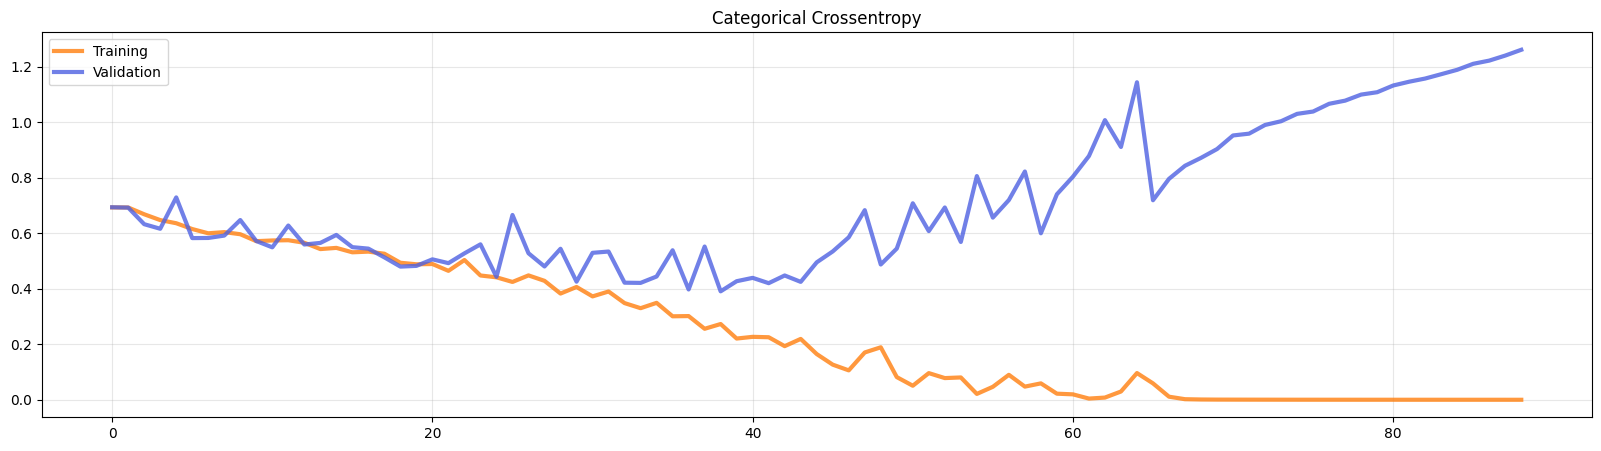

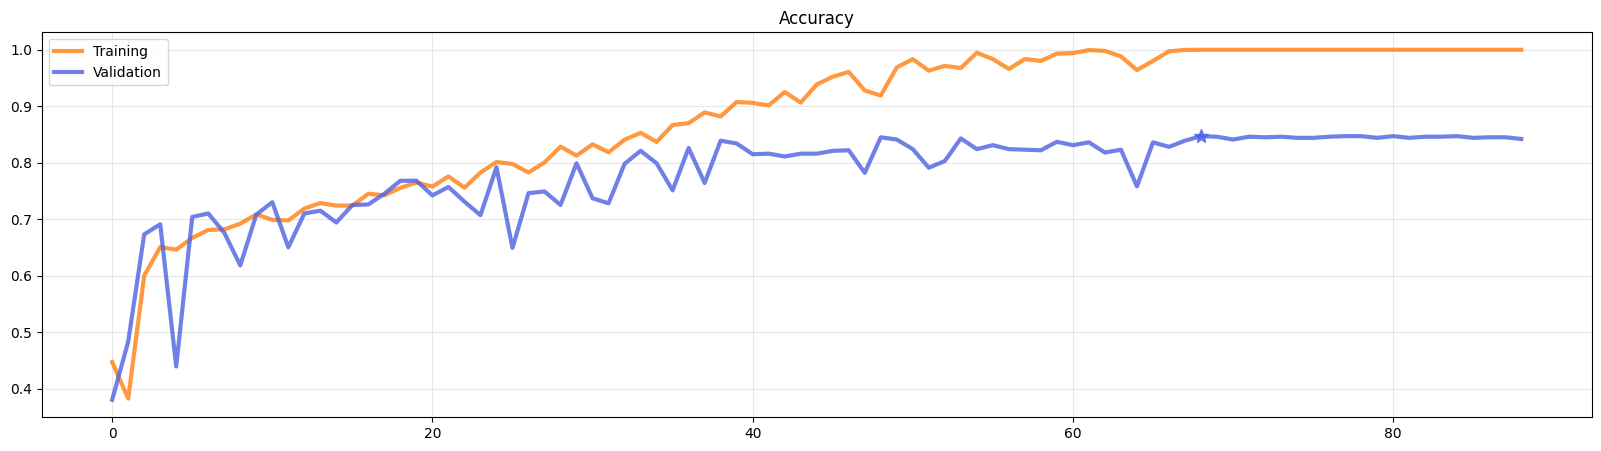

In [52]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(aug_history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(aug_history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(aug_history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(aug_history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(aug_history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, aug_history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
quasiVGG9.save('saved006_model')
del quasiVGG9